In [4]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.major.pad']='16'

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.log_device_placement    = True
#     config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session
tf.__version__


'1.2.0'

In [5]:
code_length = 10
output_image = 32

data = np.random.choice([-1, 1], size=(20000, 10))
input_data = data[0:18000]
val_data = data[-2000:]

In [13]:
#style calculation
import vgg19

# gram matrix per layer
def gram_matrix(x):
    assert isinstance(x, tf.Tensor)
    b, h, w, ch = x.get_shape().as_list()
    features = tf.reshape(x, [-1, h*w, ch])
    gram = tf.matmul(features, features, transpose_b=True)/tf.constant(ch*w*h, tf.float32)
    return gram

def lrelu(x, alpha=0.2, name=""):
  return tf.nn.relu(x) - alpha * tf.nn.relu(-x)

In [8]:
tf.reset_default_graph()
sess = get_session()

vgg_s = vgg19.Vgg19()
np_target_style_image = np.asarray(plt.imread('style.png'))
target_style_image = tf.constant(np_target_style_image[np.newaxis, :, :, 0:3])
vgg_s.build(tf.image.resize_images(target_style_image, (224, 224)))
# feature_ = [vgg_s.conv1_2, vgg_s.conv2_2, vgg_s.conv3_3, vgg_s.conv4_3, vgg_s.conv5_3]
feature_ = [vgg_s.conv4_3, vgg_s.conv5_3]
gram_ = [gram_matrix(l) for l in feature_]

gram_s = sess.run([gram_])

/home/ubuntu/build/visualMarkers/vgg19.npy
npy file loaded
build model started
build model finished: 1s


In [ ]:

tf.reset_default_graph()
sess = get_session()

# synthesizer network
_input = tf.placeholder(tf.float32, [None, code_length])
isTraining = tf.placeholder(tf.bool)

# dense_layer = tf.layers.dense(input_, output_image * output_image * 3, activation=tf.nn.relu, name='dense1')
sy_dl1 = tf.layers.dense(_input, 8 * 8 * 64, activation=lrelu, name='dense1') 
sy_dl1_r = tf.reshape(sy_dl1, (-1, 8, 8, 64)) # [-1, 8, 8, 64]

# [N, 8, 8, 128] x [3, 3] = [N, 8, 8, 64]
sy_cn1 = tf.layers.conv2d(sy_dl1_r, 64, 3, 1, padding="same")
sy_batch1 = tf.layers.batch_normalization(sy_cn1, axis=3, training=isTraining)
sy_relu1 = lrelu(sy_batch1, name="relu1")
tf.summary.histogram('relu1', sy_relu1)

# [N, 8, 8, 64] x [3, 3] = [N, 8, 8, 32]
sy_cn2 = tf.layers.conv2d(sy_relu1, 32, 3, 1, padding="same")
sy_batch2 = tf.layers.batch_normalization(sy_cn2, axis=3, training=isTraining)
sy_relu2 = lrelu(sy_batch2, name="relu2")
tf.summary.histogram('relu2', sy_relu2)

# [N, 8, 8, 32] x [3, 3] = [N, 16, 16, 32]
sy_cnt1 = tf.layers.conv2d_transpose(sy_relu2, 32, 3, 2, padding="same")
sy_batch3 = tf.layers.batch_normalization(sy_cnt1, axis=3, training=isTraining)
sy_relu3 = lrelu(sy_batch3, name="relu3")
tf.summary.histogram('relu3', sy_relu3)

# [N, 16, 16, 32] x [3, 3] = [N, 16, 16, 64]
sy_cn3 = tf.layers.conv2d(sy_relu3, 64, 3, 1, padding="same")
sy_batch4 = tf.layers.batch_normalization(sy_cn3, axis=3, training=isTraining)
sy_relu4 = lrelu(sy_batch4, name="relu4")
tf.summary.histogram('relu4', sy_relu4)

# [N, 16, 16, 64] x [3, 3] = [N, 16, 16, 32]
sy_cn4 = tf.layers.conv2d(sy_relu4, 32, 3, 1, padding="same")
sy_batch5 = tf.layers.batch_normalization(sy_cn4, axis=3, training=isTraining)
sy_relu5 = lrelu(sy_batch5, name="relu5")
tf.summary.histogram('relu5', sy_relu5)

# [N, 16, 16, 32] x [3, 3] = [N, 32, 32, 3]
sy_ctn2 = tf.layers.conv2d_transpose(sy_relu5, 32, 3, 2, padding="same")
sy_batch6 = tf.layers.batch_normalization(sy_ctn2, axis=3, training=isTraining)
sy_relu6 = lrelu(sy_batch6, name="relu6")
tf.summary.histogram('relu6', sy_relu6)

# [N, 32, 32, 3] x [3, 3] = [N, 32, 32, 3]
sy_cn5 = tf.layers.conv2d(sy_relu6, 3, 3, 1, padding="same")
sy_batch7 = tf.layers.batch_normalization(sy_cn5, axis=3, training=isTraining)
sy_output_image = tf.nn.sigmoid(sy_batch7, name="relu7")
tf.summary.histogram('relu7', sy_output_image)

tf.summary.image('marker', sy_output_image)

#recognizer network
conv1 = tf.layers.conv2d(sy_output_image, 96, [5, 5], padding='same', name='conv1') # [32, 32, 96]
kernel_conv1 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv1/kernel')[0]
bias_conv1 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv1/bias')[0]
tf.summary.histogram('conv1/kernel', kernel_conv1)
tf.summary.histogram('conv1/bias', bias_conv1)

pool1 = tf.layers.max_pooling2d(conv1, [2, 2], 2, padding='valid') # [16, 16, 96]
batch1 = tf.layers.batch_normalization(pool1, axis=3, training=isTraining)
relu1 = tf.nn.relu(batch1) # [16, 16, 96]

conv2 = tf.layers.conv2d(relu1, 96, [5, 5], padding='same', name='conv2') # [16, 16, 96]
kernel_conv2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2/kernel')[0]
bias_conv2 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv2/bias')[0]
tf.summary.histogram('conv2/kernel', kernel_conv2)
tf.summary.histogram('conv2/bias', bias_conv2)

pool2 = tf.layers.max_pooling2d(conv2, [2, 2], 2, padding='valid') # [8, 8, 96]
batch2 = tf.layers.batch_normalization(pool2, axis=3, training=isTraining)
relu2 = tf.nn.relu(batch2) # [8, 8, 96]

conv3 = tf.layers.conv2d(relu2, 96, [5, 5], padding='same', name='conv3') # [8, 8, 96]
kernel_conv3 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv3/kernel')[0]
bias_conv3 = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv3/bias')[0]
tf.summary.histogram('conv3/kernel', kernel_conv3)
tf.summary.histogram('conv3/bias', bias_conv3)

pool3 = tf.layers.max_pooling2d(conv3, [2, 2], 2, padding='valid') # [4, 4, 96]
batch3 = tf.layers.batch_normalization(pool3, axis=3, training=isTraining)
relu3 = tf.nn.relu(batch3) # [4, 4, 96]

flat_relu3 = tf.reshape(relu3, (-1, 4 * 4 * 96))
fc1 = tf.layers.dense(flat_relu3, 192)
fc2 = tf.layers.dense(fc1, code_length)

vgg_s = vgg19.Vgg19()
np_target_style_image = np.asarray(Image.open('style.jpg').convert('RGB'))
target_style_image = tf.constant(np_target_style_image[np.newaxis, :, :, 0:3])
vgg_s.build(tf.image.resize_images(target_style_image, (224, 224)))
# feature_ = [vgg_s.conv1_2, vgg_s.conv2_2, vgg_s.conv3_3, vgg_s.conv4_3, vgg_s.conv5_3]
feature_ = [vgg_s.conv3_3, vgg_s.conv4_3, vgg_s.conv5_3]
gram_ = [gram_matrix(l) for l in feature_]

vgg = vgg19.Vgg19()
vgg.build(tf.image.resize_images(sy_output_image[0:1,:,:,:], (224, 224)))
# feature = [vgg.conv1_2, vgg.conv2_2, vgg.conv3_3, vgg.conv4_3, vgg.conv5_3]
feature = [vgg.conv3_3, vgg.conv4_3, vgg.conv5_3]
gram = [gram_matrix(l) for l in feature]

style_loss = tf.zeros(1, tf.float32)
for g, g_ in zip(gram, gram_):
    style_loss += 1e1 * tf.reduce_mean(tf.subtract(g, g_) ** 2)
# for idx in range(2):
#     style_loss += 1e1 * tf.reduce_mean(tf.subtract(gram[idx], tf.constant(gram_s[0][idx])) ** 2)

# loss function is element wise sigmoid
# mean_loss = tf.losses.mean_squared_error(input_, fc2)
# sigmoid_loss = tf.losses.sigmoid_cross_entropy(tf.cast(input_, tf.int32), fc2)
mean_loss = tf.losses.mean_squared_error(_input, fc2)
# sigmoid_loss = -tf.multiply(tf.reduce_mean(tf.sigmoid(tf.multiply(input_, fc2))), tf.constant(1.))

style_loss = tf.reshape(style_loss, ())
# loss = mean_loss + style_loss
loss = style_loss
tf.summary.scalar('mean_loss', mean_loss)
tf.summary.scalar('overall_loss', loss)
tf.summary.scalar('style_loss', style_loss)
optimizer = tf.train.AdamOptimizer(learning_rate=1e0)

merged = tf.summary.merge_all()

previous_runs = os.listdir('./train')
if len(previous_runs) == 0:
    run_number = 1
else:
    run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1

logdir = 'run_%02d' % run_number
writer = tf.summary.FileWriter(os.path.join('./train', logdir), sess.graph)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train = optimizer.minimize(loss)


sess.run(tf.global_variables_initializer())

/home/ubuntu/build/visualMarkers/vgg19.npy
npy file loaded
build model started
build model finished: 1s
/home/ubuntu/build/visualMarkers/vgg19.npy
npy file loaded
build model started
build model finished: 1s


  0%|          | 0/18000 [00:00<?, ?it/s]

loss:  1.0230981 1414418200000000.0


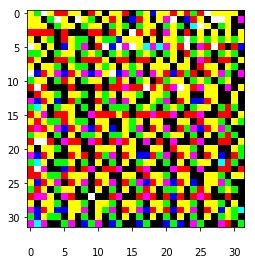

  3%|▎         | 500/18000 [03:27<2:01:01,  2.41it/s]

loss:  1.0530554 1414324500000000.0


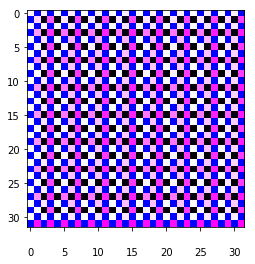

  6%|▌         | 1000/18000 [06:58<1:58:39,  2.39it/s]

loss:  2.9188704 1414323200000000.0


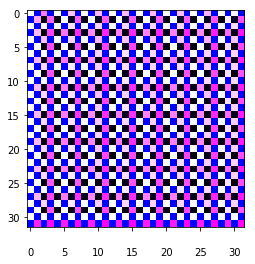

  8%|▊         | 1500/18000 [10:37<1:56:51,  2.35it/s]

loss:  2.9634173 1414323700000000.0


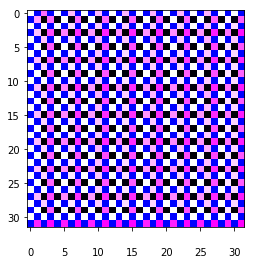

 11%|█         | 2000/18000 [14:17<1:54:20,  2.33it/s]

loss:  3.144493 1414323700000000.0


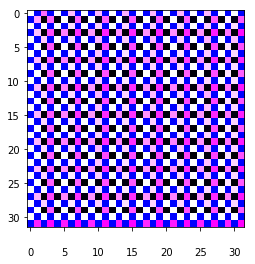

 14%|█▍        | 2500/18000 [17:59<1:51:32,  2.32it/s]

loss:  3.64596 1414324300000000.0


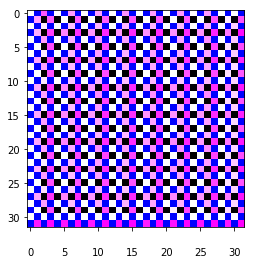

 17%|█▋        | 3000/18000 [21:39<1:48:15,  2.31it/s]

loss:  3.0859203 1414324300000000.0


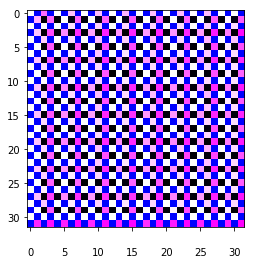

 19%|█▉        | 3500/18000 [25:20<1:45:00,  2.30it/s]

loss:  2.7883034 1414324300000000.0


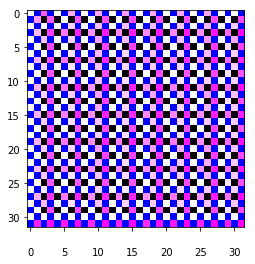

 22%|██▏       | 4000/18000 [28:59<1:41:26,  2.30it/s]

loss:  3.393256 1414323500000000.0


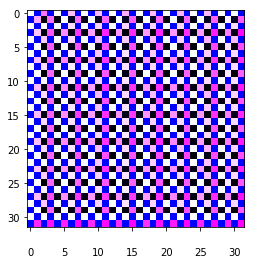

 25%|██▌       | 4500/18000 [32:39<1:37:58,  2.30it/s]

loss:  3.2911503 1414322700000000.0


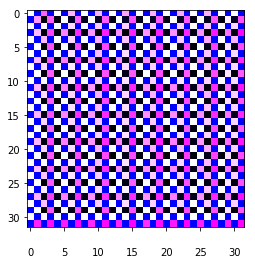

 28%|██▊       | 5000/18000 [36:20<1:34:28,  2.29it/s]

loss:  2.7708497 1414325100000000.0


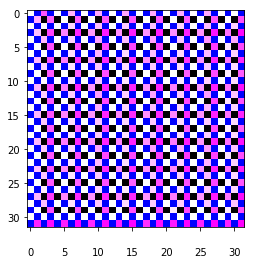

 31%|███       | 5500/18000 [40:02<1:30:59,  2.29it/s]

loss:  3.5170805 1414322700000000.0


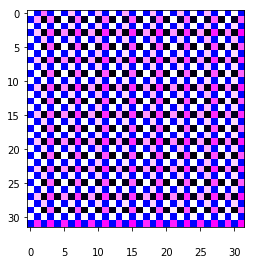

 33%|███▎      | 6000/18000 [43:46<1:27:32,  2.28it/s]

loss:  3.509385 1414322100000000.0


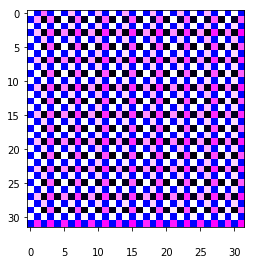

 36%|███▌      | 6500/18000 [47:15<1:23:37,  2.29it/s]

loss:  3.0310686 1414315400000000.0


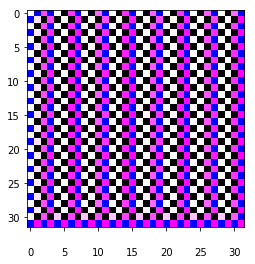

 39%|███▉      | 7000/18000 [50:39<1:19:36,  2.30it/s]

loss:  4.2830634 1414311800000000.0


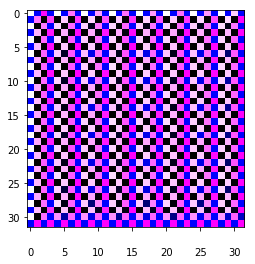

 42%|████▏     | 7500/18000 [54:03<1:15:41,  2.31it/s]

loss:  3.2766488 1414301500000000.0


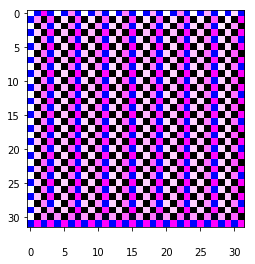

 44%|████▍     | 8000/18000 [57:29<1:11:52,  2.32it/s]

loss:  3.0522528 1414300900000000.0


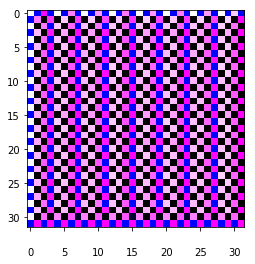

 47%|████▋     | 8500/18000 [1:00:56<1:08:07,  2.32it/s]

loss:  3.1543694 1414300200000000.0


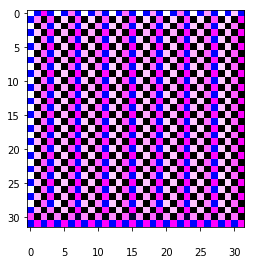

 50%|█████     | 9000/18000 [1:04:22<1:04:22,  2.33it/s]

loss:  3.0012336 1414300900000000.0


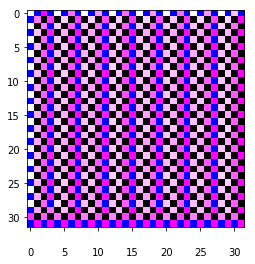

 53%|█████▎    | 9500/18000 [1:07:46<1:00:38,  2.34it/s]

loss:  3.1558108 1414300700000000.0


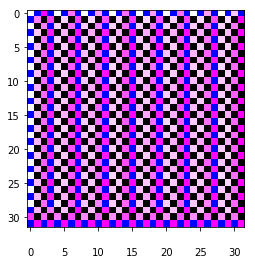

 55%|█████▍    | 9868/18000 [1:10:14<57:53,  2.34it/s]  

In [ ]:
#missing Trainable batch norm thingy
for i in tqdm(range(200 * 90)):
    batch_ = np.random.randint(9000, size=200)
    x = sess.run([train, merged, gram_], feed_dict={_input : input_data[batch_, :], isTraining : True})
    if i % 50 == 0:
        writer.add_summary(x[1], i)

    if i % 500 == 0:
        x = sess.run([mean_loss, style_loss], feed_dict={_input : val_data, isTraining : False})
        print('loss: ', x[0], x[1])
        
        #print a sample output
        check_data = np.random.choice([-1, 1], size=(1, 10))
        #print(check_data[0])
        image_output = sess.run([sy_output_image], feed_dict={_input : check_data, isTraining : False})
        image_output1 = np.reshape(image_output[0], (output_image, output_image, 3))
        plt.figure(figsize=(4, 4))
        plt.imshow(image_output1)
        plt.show()



In [2]:
tf.con
check_data = np.random.choice([-1, 1], size=(1, 10))
print(check_data[0])
image_output = sess.run([fc2], feed_dict={_input : check_data, isTraining : False})
print(image_output[0].shape)
print(np.sign(image_output[0][0]))
# image_output1 = np.reshape(image_output[0], (output_image, output_image, 3))
# plt.figure(figsize=(4, 4))
# plt.imshow(image_output1)

# plt.show(image_output)
# print(np.sign(image_output[0][0]))
# image_output1 = np.reshape(image_output[0], (output_image, output_image, 3))
# plt.imshow(image_output1)

# print(sess.run([fc2], feed_dict={input_ : check_data, isTraining: False}))

AttributeError: module 'tensorflow' has no attribute 'con'